## TE Connect CNN-LSTM Attempt

Author: Alexiy Buynitsky

Resources:
https://towardsdatascience.com/cnn-lstm-based-models-for-multiple-parallel-input-and-multi-step-forecast-6fe2172f7668

https://github.com/lkulowski/LSTM_encoder_decoder

TODO:
- Add baseline model using running averages as a comparison
- Add ways to control all paramters in global classes
- add cnn-lstm model
- Double check all data is added as training and testing split

## Imports

In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from torchvision import datasets, transforms
import random as random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

## Data Prep

In [100]:


df = pd.read_csv("te_ai_cup_sales_forecasting_data.csv")
print("num rows:", len(df))
print("num cols:", df.shape[1])
df["year_week_ordered"] = df['fiscal_year_historical'] + \
    df['fiscal_week_historical']
df.sort_values(by=['fiscal_year_historical'] +
               ['fiscal_week_historical'], inplace=True)
df.reset_index(drop=True, inplace=True)
u_prod_code = df["product_line_code"].unique()
print(u_prod_code)
df["Price"] = df["sales_amount"]/df["sales_quantity"]
display(df.head(10))


num rows: 522698
num cols: 10
['E77' '053' '202' 'ABP' 'AC5' '607' 'AC6' '088' 'H98' 'DK4' 'N65' '372'
 'FG2' '251' '208' 'F49' 'H90' 'J67' 'J63' '073' '351' '050' 'K70' '301'
 'J37' 'A13' 'AQ9' '038' '025' '440' '481' '145' '230' 'K85' 'JB3' '547'
 '239' '912' '281' '231' 'LT0' '214' 'JF1' 'A28' '567' 'B91' '438' '430'
 'K00' 'J89' 'E31' 'Z27' '291' 'Z83' 'G60' '518' '472' 'F52' 'G59' '042'
 'N09' '323' '715' 'A05' '072' '397' '957' 'J25' '217' '014' '224' 'G49'
 '344' '207' 'AP2' '002' '529' '077' 'E82' '835' 'LV4' '728' '890' '032'
 '757' 'E79' '097' 'Z34' '057' 'F38' 'Z43' 'F83' 'F82' 'G74' 'AG7' '685'
 '977' '009' 'A92' '712' 'F50' '001' 'JH4' '402' '124' '023' '961' '313'
 'G61' 'F48' '056' 'G41' '232' '766' '519' 'J12' '243' 'LV1' '204' 'F41'
 '450' '516' 'W02' 'Z40' '080' '289' '036' '394' '150' 'JC1' 'J46' 'AH8'
 '046' 'F40' '716' 'G30' 'B77' 'JJ4' 'C19' 'DA8' 'K80' '327' 'E83' 'F46'
 '350' 'J45' '748' 'Z77' 'N73' '914' 'JE2' '085' 'JC3' '312' '127' 'J96'
 '760' '076' 'K18' 'N

,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Energy,EMEA,E77,LV/MV Surge Arresters,1641.00,126789.47,2016,77.263541
1,2015,1,1,1,Channel - Data and Devices,Asia Pacific & ANZ,053,Memory Sockets,14417.92,17379.52,2016,1.205411
2,2015,1,1,1,Channel - Industrial,EMEA,202,PLASTI-GRIP Terminals,142820.40,19666.38,2016,0.137700
3,2015,1,1,1,Industrial,Americas,ABP,Specific terminal blocks,14528.00,-12089.77,2016,-0.832170
4,2015,1,1,1,Data and Devices,EMEA,AC5,"Antennas, Custom Others",34400.00,30357.47,2016,0.882485
5,2015,1,1,1,Appliances,EMEA,607,DW-All Other Dual Wall,201134.00,99060.41,2016,0.492510
6,2015,1,1,1,Data and Devices,EMEA,AC6,"Antennas, Standard",1020.00,14178.82,2016,13.900804
7,2015,1,1,1,"Aerospace, Defense & Marine",Americas,088,G Series Products,22403.00,-11833.37,2016,-0.528205
8,2015,1,1,1,Industrial Commercial Transportation,Americas,H98,DTP,95563.00,82885.19,2016,0.867336
9,2015,1,1,1,Industrial,EMEA,DK4,Signal Proprietary,1894.00,16306.23,2016,8.609414


## Splitting the Data based on Specific Paramters

In [106]:
def get_raw_data(filtered_df, business_unit_group_name=None, company_region_name_level1=None, product_line_code=None):
    if business_unit_group_name is not None:
        filtered_df = filtered_df[filtered_df['business_unit_group_name']
                                  == business_unit_group_name]
    if company_region_name_level1 is not None:
        filtered_df = filtered_df[filtered_df['company_region_name_level_1']
                                  == company_region_name_level1]
    if product_line_code is not None:
        filtered_df = filtered_df[filtered_df['product_line_code']
                                  == product_line_code]

    if len(filtered_df) == 0:
        raise Exception("ERROR: empty dataset")
    return filtered_df


# raw_df = get_raw_data(df,company_region_name_level1= "EMEA")
raw_df = get_raw_data(df)
display(raw_df.head(10))


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Energy,EMEA,E77,LV/MV Surge Arresters,1641.00,126789.47,2016,77.263541
1,2015,1,1,1,Channel - Data and Devices,Asia Pacific & ANZ,053,Memory Sockets,14417.92,17379.52,2016,1.205411
2,2015,1,1,1,Channel - Industrial,EMEA,202,PLASTI-GRIP Terminals,142820.40,19666.38,2016,0.137700
3,2015,1,1,1,Industrial,Americas,ABP,Specific terminal blocks,14528.00,-12089.77,2016,-0.832170
4,2015,1,1,1,Data and Devices,EMEA,AC5,"Antennas, Custom Others",34400.00,30357.47,2016,0.882485
5,2015,1,1,1,Appliances,EMEA,607,DW-All Other Dual Wall,201134.00,99060.41,2016,0.492510
6,2015,1,1,1,Data and Devices,EMEA,AC6,"Antennas, Standard",1020.00,14178.82,2016,13.900804
7,2015,1,1,1,"Aerospace, Defense & Marine",Americas,088,G Series Products,22403.00,-11833.37,2016,-0.528205
8,2015,1,1,1,Industrial Commercial Transportation,Americas,H98,DTP,95563.00,82885.19,2016,0.867336
9,2015,1,1,1,Industrial,EMEA,DK4,Signal Proprietary,1894.00,16306.23,2016,8.609414


In [107]:
def group_by_unique(local_df, product_line=False, business_unit=False, company_region=False):

    group_by_list = []
    if (product_line):
        group_by_list.append("product_line_code")
    if (company_region):
        group_by_list.append("company_region_name_level_1")
    if (business_unit):
        group_by_list.append("business_unit_group_name")
    grouped_df = local_df.groupby(group_by_list)
    print(len(grouped_df))
    return grouped_df


In [108]:
grouped_df = group_by_unique(
    df, product_line=True, business_unit=True, company_region=True)
count = 0
for name, group in grouped_df:
    print(name)
    print(len(group))
    display(group.head(10))
    # display(group.head())
    count = count+1
    if count == 5:
        break


1339
('001', 'Asia Pacific & ANZ', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
108,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,305278.80,33869.70,2016,0.110947
1299,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,2017,0.110947
2484,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,2018,0.110947
3699,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,427390.32,47417.58,2019,0.110947
5763,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,43076.34,2020,0.135759
6981,2015,1,2,6,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,367401.32,49877.86,2021,0.135759
8179,2015,1,2,7,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,334001.20,45343.51,2022,0.135759
9390,2015,1,2,8,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,334001.20,45343.51,2023,0.135759
10605,2015,1,2,9,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,43076.34,2024,0.135759
10902,2015,1,3,10,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,152336.00,35769.20,2025,0.234805


('001', 'Asia Pacific & ANZ', 'Industrial')
415


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
1043,2015,1,1,1,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,513152.0,76599.06,2016,0.149272
2258,2015,1,1,2,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,179474.0,30120.36,2017,0.167826
3515,2015,1,1,3,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,473700.0,42911.32,2018,0.090588
4608,2015,1,1,4,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,331975.0,17220.96,2019,0.051874
5090,2015,1,2,5,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,515725.0,55527.06,2020,0.107668
6667,2015,1,2,6,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,265937.0,74272.87,2021,0.279287
7636,2015,1,2,7,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,399465.0,96394.33,2022,0.241309
8485,2015,1,2,8,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,713300.0,52651.69,2023,0.073814
10715,2015,1,2,9,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,94396.0,46691.94,2024,0.494639
11456,2015,1,3,10,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,156210.0,63392.99,2025,0.405819


('002', 'Americas', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
696,2015,1,1,1,Channel - Industrial,Americas,002,AMPMODU System 50,17098.00,30641.84,2016,1.792130
1894,2015,1,1,2,Channel - Industrial,Americas,002,AMPMODU System 50,22227.40,39834.40,2017,1.792130
3117,2015,1,1,3,Channel - Industrial,Americas,002,AMPMODU System 50,22227.40,39834.40,2018,1.792130
4288,2015,1,1,4,Channel - Industrial,Americas,002,AMPMODU System 50,23937.20,42898.58,2019,1.792130
5765,2015,1,2,5,Channel - Industrial,Americas,002,AMPMODU System 50,18016.37,36681.44,2020,2.036006
6983,2015,1,2,6,Channel - Industrial,Americas,002,AMPMODU System 50,20861.06,42473.25,2021,2.036006
8181,2015,1,2,7,Channel - Industrial,Americas,002,AMPMODU System 50,18964.60,38612.04,2022,2.036006
9392,2015,1,2,8,Channel - Industrial,Americas,002,AMPMODU System 50,18964.60,38612.04,2023,2.036006
10607,2015,1,2,9,Channel - Industrial,Americas,002,AMPMODU System 50,18016.37,36681.44,2024,2.036006
11890,2015,1,3,10,Channel - Industrial,Americas,002,AMPMODU System 50,24050.75,42878.82,2025,1.782848


('002', 'Americas', 'Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
176,2015,1,1,1,Industrial,Americas,002,AMPMODU System 50,38784.0,48835.78,2016,1.259173
1679,2015,1,1,2,Industrial,Americas,002,AMPMODU System 50,60028.0,80518.56,2017,1.341350
3127,2015,1,1,3,Industrial,Americas,002,AMPMODU System 50,28550.0,38572.70,2018,1.351058
4002,2015,1,1,4,Industrial,Americas,002,AMPMODU System 50,52851.0,71123.96,2019,1.345745
5857,2015,1,2,5,Industrial,Americas,002,AMPMODU System 50,40697.0,41301.96,2020,1.014865
6518,2015,1,2,6,Industrial,Americas,002,AMPMODU System 50,31013.0,49768.85,2021,1.604774
8112,2015,1,2,7,Industrial,Americas,002,AMPMODU System 50,62659.0,101831.63,2022,1.625172
8956,2015,1,2,8,Industrial,Americas,002,AMPMODU System 50,38068.0,55429.44,2023,1.456064
10581,2015,1,2,9,Industrial,Americas,002,AMPMODU System 50,16364.0,24064.56,2024,1.470579
11004,2015,1,3,10,Industrial,Americas,002,AMPMODU System 50,35642.0,66100.95,2025,1.854580


('002', 'Asia Pacific & ANZ', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
563,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,3875.80,6389.06,2016,1.648449
1763,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5038.54,8305.78,2017,1.648450
2981,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5038.54,8305.78,2018,1.648450
4153,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5426.12,8944.69,2019,1.648450
5426,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8444.93,13086.15,2020,1.549587
6678,2015,1,2,6,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,9778.34,15152.39,2021,1.549587
7881,2015,1,2,7,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8889.40,13774.90,2022,1.549587
9089,2015,1,2,8,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8889.40,13774.90,2023,1.549587
10264,2015,1,2,9,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8444.93,13086.15,2024,1.549587
10836,2015,1,3,10,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,10031.25,15437.74,2025,1.538965


In [109]:
groups = [grouped_df.get_group(x) for x in grouped_df.groups]


## Preparing the Data for Training

In [115]:
class Data_Prep:
    # must contain each one of these labels
    data_filter = ["Asia Pacific & ANZ","Channel - Industrial"]
    # collumns of interest
    data_cols = ["sales_amount", "sales_quantity", "Price"]
    percent = 0.8 # test-train split percentage
    lookback = 40 # number of units used to make prediction
    predict = 10 # number of units that will be predicted

In [116]:
for group in groups:
    df2 = group[group.duplicated('year_week_ordered')]
    # duplicate = df[df.duplicated('City')]
    display(df2.head(5))
    break


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
63701,2016,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,86862.72,21001.41,2017,0.241777
64917,2016,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,103408.00,25001.68,2018,0.241777
66124,2016,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,107544.32,26001.75,2019,0.241777
67336,2016,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,115816.96,28001.88,2020,0.241777
68333,2016,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,28652.20,16102.71,2021,0.562006


Note:
Found that there were some outlier values - might want to remove them and then interpolate on them depending on the results

In [117]:


def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"

    df.dropna(inplace=True)
    print("new len:", len(df.columns))
    return df

# TODO: need to implement removal of outliers
def removeOutliers(group, col):
    return group


In [118]:
def key_filter_match(name,data_filter):
    if len(data_filter)==0:
        return True
    for e in data_filter:
        if not e in name:
            return False
    return True

def transform_norm_rem_out(grouped_df, data_cols,data_filter):
    transformed_data = {}
    reg_data = {}
    transformations = {}
    display_once = True
    count = 0
    for name, group in grouped_df:
        if key_filter_match(name,data_filter):
            for col in data_cols:

                if len(group[col]) == 0:
                    raise Exception("Collumn does not exist!")
                # removeOutliers(group[col],col)
                # interpolate the mission values

            scalar = MinMaxScaler()
            # group[data_cols] = clean_dataset(group[data_cols]) # this line
            for i in range(0, len(group.columns)):
                group.iloc[:, i].interpolate(inplace=True)
            group = group.replace((np.inf, -np.inf, np.nan),
                                0).reset_index(drop=True)
     
            reg_data[name] = group.copy()
            transformations[name] = scalar.fit(group[data_cols])
            group[data_cols] = scalar.fit_transform(group[data_cols])
            transformed_data[name] = group
            if display_once:
                print("\n")
                print(name)
                display(transformed_data[name])
                display_once = False
            count += 1
            print(count, "/", len(grouped_df), end="\r")

    

    return reg_data, transformed_data, transformations


In [119]:
reg_data,transformed_data, transformations = transform_norm_rem_out(
    grouped_df, Data_Prep.data_cols,Data_Prep.data_filter)




('001', 'Asia Pacific & ANZ', 'Channel - Industrial')


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.307948,0.093309,2016,0.018802
1,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,2017,0.018802
2,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,2018,0.018802
3,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.443185,0.141354,2019,0.018802
4,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.321262,0.125958,2020,0.060800
...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022,4,12,49,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,2071,0.132730
414,2022,4,12,50,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.872838,0.488609,2072,0.132730
415,2022,4,12,51,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,2073,0.132730
416,2022,4,12,52,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.963136,0.540150,2074,0.132730


This was a check to make sure that transforms were being saved - they were

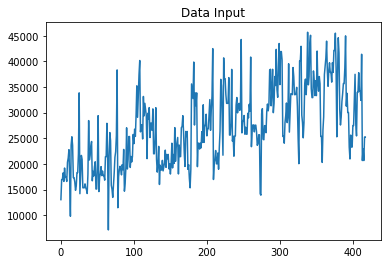

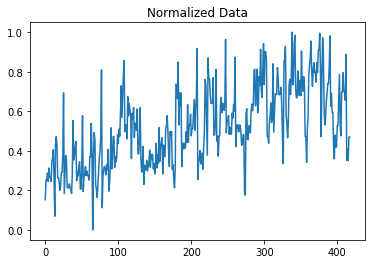

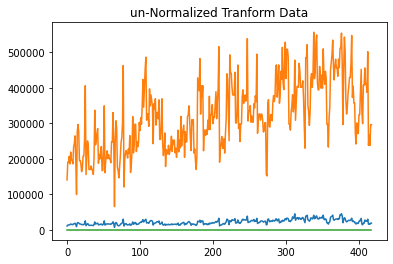

In [120]:
k = '202', 'Asia Pacific & ANZ', 'Channel - Industrial'

#display(transformed_data[k])
plt.title("Data Input")
plt.plot(reg_data[k]['sales_amount'])
plt.show()
plt.title("Normalized Data")
plt.plot(transformed_data[k]['sales_amount'])
plt.show()
transform = transformations[k]
plt.title("un-Normalized Tranform Data")
inv_t_data = transform.inverse_transform(transformed_data[k][["sales_quantity","sales_amount","Price"]])
#display(inv_t_data)
#print(np.asarray(inv_t_data).shape)
plt.plot(inv_t_data)
plt.show()
# shape is __ x 3

In [121]:

def prep_data(data, past, future, data_cols):
    x, y = list(), list()
    data_arr = data[data_cols].to_numpy()
    print(data_arr.shape)
    for i in range(len(data_arr)):
        lag_end = i+past
        forcast_end = lag_end+future
        if forcast_end > len(data):
            break
        x.append(data_arr[i:lag_end])
        y.append(data_arr[lag_end:forcast_end])
    return np.array(x), np.array(y)


In [122]:

num_features = len(Data_Prep.data_cols)
show_sample = False
dict_train_data = {}
dict_valid_data = {}
all_valid_data = []
all_train_data = []
for key, group in transformed_data.items():
    split = (int)(len(group)*Data_Prep.percent)
    train_data = group[0:split]
    valid_data = group[split:]
    x_train, x_test = prep_data(train_data, Data_Prep.lookback, Data_Prep.predict, Data_Prep.data_cols)
    y_train, y_test = prep_data(valid_data, Data_Prep.lookback, Data_Prep.predict, Data_Prep.data_cols)

    if show_sample:
        print("train:")
        print(x_train.shape)
        print(x_train[0])
        print(x_test.shape)
        print(x_test[0])
        print("valid:")
        print(y_train.shape)
        print(y_train[0])
        print(y_test.shape)
        print(y_test[0])
        show_sample = False
    all_train_data.append((x_train, x_test))
    all_valid_data.append((y_train, y_test))
    dict_valid_data[key] = (x_train, x_test)
    dict_train_data[key] = (y_train, y_test)

(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(300, 3)
(76, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(292, 3)
(74, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(331, 3)
(83, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(327, 3)
(82, 3)
(334, 3)
(84, 3)
(334, 3)
(84, 3)
(321, 3)
(81, 3)
(334, 3)
(84, 3)


In [123]:
all_valid_data = np.array(all_valid_data,dtype=object)
all_train_data = np.array(all_train_data,dtype=object)
print(len(all_valid_data))
print(len(all_train_data))

print(all_valid_data.shape)
print(all_train_data.shape)

def get_all_data_arr(all_data):
    tr = []
    te= []
    for i in range(len(all_data)):
        x_tr = all_data[i][0]
        x_te = all_data[i][1]
        for j in range(len(x_tr)):
            tr.append(x_tr[j])
            te.append(x_te[j])
    return np.array(tr),np.array(te)

train_y,test_y = get_all_data_arr(all_valid_data)
train_x,test_x = get_all_data_arr(all_train_data)

print("y train shape:",train_y.shape)
print("y test shape:",test_y.shape)

print("x train shape:",train_x.shape)
print("x test shape:",test_x.shape)


56
56
(56, 2)
(56, 2)
y train shape: (1936, 40, 3)
y test shape: (1936, 10, 3)
x train shape: (15861, 40, 3)
x test shape: (15861, 10, 3)


## Model Info

In [140]:
class Model_Info:
    batch_size = 1024
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    count_print_batch = 4 # the number of times training loss printed for each epoch
    learning_rate = 0.01
    epochs = 50
    model_save_path = "/home/abuynits/Projects/TE_Connect/savedModels/"
    save_model = False
    hidden_size = 2 # the number of features in the stacked lstm
    enc_drop = 0.25
    dec_drop = 0.25
    num_layers = 2
    train_prediction = 'recursive'
    
    

In [132]:
class finance_data_set(Dataset):
    def __init__(self, trainDT, testDT):
        super().__init__()
        self.train = trainDT
        self.test = testDT
        self.data_len = len(trainDT)

    def __len__(self):
        return self.data_len

    def __getitem__(self, i):
        tr = torch.from_numpy(self.train[i]).float()
        te = torch.from_numpy(self.test[i]).float()
        return (tr,te)


# train_ds = finance_data_set(x_train, x_test)
# test_ds = finance_data_set(y_train, y_test)

train_ds = finance_data_set(train_x, test_x)
test_ds = finance_data_set(train_y, test_y)
print(x_train.shape)
print(all_train_data[1][0].shape)
#train_ds = finance_data_set(all_train_data[0], all_train_data[1])
#test_ds = finance_data_set(all_valid_data[0], all_valid_data[1])

test_dl = DataLoader(test_ds, batch_size=Model_Info.batch_size, shuffle=True)
print(f"batches in test dl: {len(test_dl)}")
train_dl = DataLoader(train_ds, batch_size=Model_Info.batch_size, shuffle=True)
print(f"batches in train dl: {len(train_dl)}")

print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(test_dl))[0].shape)
print(next(iter(test_dl))[1].shape)



(285, 40, 3)
(285, 40, 3)
batches in test dl: 2
batches in train dl: 16
torch.Size([1024, 40, 3])
torch.Size([1024, 10, 3])
torch.Size([1024, 40, 3])
torch.Size([1024, 10, 3])


In [133]:


"""
stacked lstm: each layer contains multiple memory cells
make the model deeper

"""


class enc_lstm(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.25,num_layers=1):
        super(enc_lstm, self).__init__()
        self.input_size = input_size  # number of input features
        self.hidden_size = hidden_size  # number of features in hidden state
        self.num_layers = num_layers  # number of stacked LSTM's

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size, num_layers=self.num_layers,dropout=dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, inp):
        """
        Args:
            inp: input of shape (seq_len, # in batch, input_size)
            return lstm_out, hidden
            lstm_out: hive hidden states in seq
            hidden: gives hidden state and cell state for last element in seq

        lstm_out: encoder vecotr; acts as init hidden state of decoder part of model
        """
        inp = self.drop(inp)
        lstm_out, self.hidden = self.lstm(
            inp.view(inp.shape[0], inp.shape[1], self.input_size))
        
        return lstm_out.to(Model_Info.device), self.hidden

    def init_hidden(self, batch_size):
        """inits hidden state

        Args:
            batch_size (int): x_input.shape[1] 
        Return:
            zeroed hidden state and cell state
        """

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(Model_Info.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(Model_Info.device))


class dec_lstm(nn.Module):
    # decodes hidden state output by encoder
    def __init__(self, input_size, hidden_size, dropout=0.25,num_layers=1):
        super(dec_lstm, self).__init__()
        self.input_size = input_size  # num features in input X
        self.hidden_size = hidden_size  # num of features in hidden state h
        self.num_layers = num_layers  # number of stacked lstms
        self.dropout=dropout
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size, num_layers=num_layers,dropout=dropout)
        self.linear = nn.Linear(hidden_size, input_size)
        self.drop = nn.Dropout(self.dropout)        


    def forward(self, inp, enc_hidden_states):
        # inp: 2d: batch_size, input_size
        # enc_hidden_states: hidden states of encoder
        lstm_out, self.hidden = self.lstm(inp.unsqueeze(0), enc_hidden_states)
        output = self.linear(lstm_out.squeeze(0))

        return output.to(Model_Info.device), self.hidden


class seq2seq_lstm(nn.Module):

    def __init__(self, input_size, hidden_size,enc_drop=0.25,dec_drop=0.25,num_layers=1,teacher_forcing_ratio=0.5,train_prediction = None):
        super(seq2seq_lstm, self).__init__()
        self.input_size = input_size  # number of features in input state
        self.hidden_size = hidden_size  # number features in hidden state
        self.num_layers = num_layers
        self.enc_drop = enc_drop
        self.dec_drop = dec_drop
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.train_prediction = train_prediction

        self.enc = enc_lstm(input_size=self.input_size, hidden_size=self.hidden_size,dropout=self.enc_drop,num_layers=self.num_layers)
        self.dec = dec_lstm(input_size=self.input_size, hidden_size=self.hidden_size,dropout=self.dec_drop,num_layers=self.num_layers)

    def forward(self,inp,model_out=None):
        
        outputs = torch.zeros(Data_Prep.predict,inp.shape[1],num_features).to(Model_Info.device)
        hidden,cell=self.enc.init_hidden(batch_size=Model_Info.batch_size)
        
        enc_out,(hidden,cell) = self.enc(inp)
        dec_inp = inp[-1, :,:] # reshape the input to (batch_size,input_size)
        if self.train_prediction == 'recursive' or model_out is None:
            for t in range(num_features):
                dec_out,(cell,hidden) = self.dec(dec_inp,(cell,hidden))
                outputs[t]=dec_out
                dec_inp = dec_out
        elif self.train_prediction == 'teacher forcing' and not model_out is None:
            
                if random.random() < self.teacher_forcing_ratio:
                    for t in range(num_features):
                        dec_out, (cell,hidden) = self.dec(dec_inp,(cell,hidden))
                        outputs[t]=dec_out
                        dec_inp = model_out[t, :, :]
                else:
                    for t in range(num_features):
                        dec_out, (cell,hidden) = self.dec(dec_inp,(cell,hidden))
                        outputs[t]=dec_out
                        dec_inp = dec_out
        elif self.train_prediction == 'mixed teacher forcing' and not model_out is None:
            for t in range(num_features):
                dec_out, (cell,hidden) = self.dec(dec_inp,(cell,hidden))
                outputs[t] = dec_out
                
                if random.random() < self.teacher_forcing_ratio:
                    dec_inp = model_out[t, :, :]
                else:
                    dec_inp = dec_out
        else:
            raise Exception("Error: invalid training option selected")

        return outputs

## Training Loop

In [134]:
model = seq2seq_lstm(num_features, hidden_size=Model_Info.hidden_size,enc_drop=Model_Info.enc_drop,dec_drop=Model_Info.dec_drop,num_layers=Model_Info.num_layers,train_prediction=Model_Info.train_prediction)

model = model.to(Model_Info.device)
optim = optimizer.Adam(model.parameters(), lr=Model_Info.learning_rate)
loss_func = nn.MSELoss()
print(model)
def count_params(model):
    sum = 0
    for param in model.parameters():
        if param.requires_grad:
           sum+=param.numel() 
    return sum
print(f"{count_params(model)} trainable params")


seq2seq_lstm(
  (enc): enc_lstm(
    (lstm): LSTM(3, 2, num_layers=2, dropout=0.25)
    (drop): Dropout(p=0.25, inplace=False)
  )
  (dec): dec_lstm(
    (lstm): LSTM(3, 2, num_layers=2, dropout=0.25)
    (linear): Linear(in_features=2, out_features=3, bias=True)
    (drop): Dropout(p=0.25, inplace=False)
  )
)
217 trainable params


In [142]:

train_loss = []
val_loss = []

def train_one_epoch(epoch: int, dl):
    model.train(True)
    last_loss = 0.
    print_batch_loss = len(dl)/Model_Info.count_print_batch
    print_batch_count = 0.0
    run_loss = 0.0
    total_loss = 0.0
    num_run = 0.0
    for i, (model_inp, model_out) in enumerate(dl):

        optim.zero_grad()

        model_inp=model_inp.swapaxes(0,1)
        model_out=model_out.swapaxes(0,1)

        if torch.cuda.is_available():
            model_inp = model_inp.cuda() 
            model_out = model_out.cuda()
        
        
        pred_out = model.forward(model_inp,model_out)
        if torch.cuda.is_available():
            pred_out=pred_out.cuda()
        loss = loss_func(pred_out, model_out)
        loss.backward()
        optim.step()

        run_loss += loss.item()
        total_loss += loss.item()
        num_run+=1
        print_batch_count+=1
        if (((i+1) % print_batch_loss) == 0 and i != 0):
            last_loss = run_loss/print_batch_count
            train_loss.append(((i+1)+epoch*len(dl),last_loss))
            print('    epoch {} batch {}/{} loss: {}'.format(epoch, i+1,len(dl), last_loss))
            run_loss = 0.0
            print_batch_count = 0.0
    return total_loss/num_run


def test_one_epoch(epoch: int, dl):
    model.train(False)
    run_loss = 0.0
    batch_count = 0
    for i, (val_inp, val_out) in enumerate(dl):
        val_inp=val_inp.swapaxes(0,1)
        val_out=val_out.swapaxes(0,1)
        if torch.cuda.is_available():
            val_inp = val_inp.cuda() 
            val_out = val_out.cuda()
        
        out = model(val_inp)
        batch_count += 1
        loss = loss_func(out, val_out)
        run_loss += loss.item()
    return run_loss/batch_count


# train loop:
best_vloss = 1_000_000.
for i in range(Model_Info.epochs):
    avg_train_loss = train_one_epoch(i, train_dl)
    avg_val_loss = test_one_epoch(i, test_dl)
    val_loss.append((train_loss[-1][0], avg_val_loss))

    print(f"epoch {i}: avg train loss: {avg_train_loss} avg val loss: {avg_val_loss}")
    if Model_Info.save_model:
        if avg_val_loss < best_vloss:
            best_vloss = avg_val_loss
            print(f"saving: {best_vloss}")
            model_path = '{}{}_{}_{}'.format(
                Model_Info.model_save_path, "model_name", best_vloss, i)
            torch.save(model.state_dict(), model_path)

    epoch 0 batch 4/16 loss: 0.08441080152988434
    epoch 0 batch 8/16 loss: 0.08497002720832825
    epoch 0 batch 12/16 loss: 0.08622151054441929
    epoch 0 batch 16/16 loss: 0.08344924449920654
epoch 0: avg train loss: 0.0847628959454596 avg val loss: 0.18113677948713303
    epoch 1 batch 4/16 loss: 0.08496943861246109
    epoch 1 batch 8/16 loss: 0.08448116481304169
    epoch 1 batch 12/16 loss: 0.08408293686807156
    epoch 1 batch 16/16 loss: 0.08506770059466362
epoch 1: avg train loss: 0.08465031022205949 avg val loss: 0.18007782846689224
    epoch 2 batch 4/16 loss: 0.08491542749106884
    epoch 2 batch 8/16 loss: 0.08373600617051125
    epoch 2 batch 12/16 loss: 0.08314234390854836
    epoch 2 batch 16/16 loss: 0.08523514494299889
epoch 2: avg train loss: 0.08425723062828183 avg val loss: 0.1787828579545021
    epoch 3 batch 4/16 loss: 0.08477110788226128
    epoch 3 batch 8/16 loss: 0.08489234931766987
    epoch 3 batch 12/16 loss: 0.08274686522781849
    epoch 3 batch 16/16

KeyboardInterrupt: 

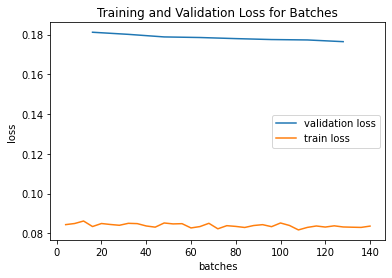

In [143]:
tl=np.array(train_loss).T
vl=np.array(val_loss).T
plt.plot(vl[0],vl[1], label = "validation loss")
plt.plot(tl[0],tl[1], label = "train loss")
plt.legend()
plt.title("Training and Validation Loss for Batches")
plt.ylabel("loss")
plt.xlabel("batches")
plt.show()

In [144]:
def predict_tensor(model: seq2seq_lstm,inp_tensor, target_len:int):
    """predicts the output for a specific input

    Args:
        model (seq2seq_lstm): the model
        inp_tensor (tensor): input tensor that is already normalized
        target_len (int): the target prediction length

    Returns:
        numpy array of outputs: the predicted seq for the specifed price
    """
    inp_tensor = inp_tensor.unsqueeze(1) # add in batch size of 1
    model.train(False)
    enc_out,enc_hidden = model.enc(inp_tensor)
    
    outputs = torch.zeros(target_len,inp_tensor.shape[2])
    dec_inp = inp_tensor[-1,:,:]
    dec_hidden = enc_hidden
    
    for t in range(target_len):
        dec_out,dec_hidden = model.dec(dec_inp,dec_hidden)
        outputs[t] = dec_out.squeeze(0) # collapse the 1 batch size
        dec_inp = dec_out # move over the input
    np_out = outputs.detach().numpy()
    return np_out
    

In [145]:
data_filter = ["001"]
#data_cols = ["sales_amount", "sales_quantity", "Price"]
data_cols = ["sales_amount"]
reg_data, transformed_data, transformations = transform_norm_rem_out(
    grouped_df, data_cols,data_filter)




('001', 'Asia Pacific & ANZ', 'Channel - Industrial')


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,305278.80,0.093309,2016,0.110947
1,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,0.129342,2017,0.110947
2,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,0.129342,2018,0.110947
3,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,427390.32,0.141354,2019,0.110947
4,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,0.125958,2020,0.135759
...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022,4,12,49,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,733807.80,0.437068,2071,0.178254
414,2022,4,12,50,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,815342.00,0.488609,2072,0.178254
415,2022,4,12,51,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,733807.80,0.437068,2073,0.178254
416,2022,4,12,52,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,896876.20,0.540150,2074,0.178254


In [148]:
for key,val in enumerate(transformed_data):
    #print(val)
    x,y = prep_data(transformed_data[val], Data_Prep.lookback, Data_Prep.predict, data_cols)
    print(x.shape)
    print(y.shape)
    index_graphing = 0
    for i in range(len(x)):
        x_axis = np.array(transformed_data[val]["year_week_ordered"][i+len(x[1]):i+len(x[1])+Data_Prep.predict])
        model_inp = torch.from_numpy(x[i]).float().to(Model_Info.device)
        pred = predict_tensor(model,model_inp,Data_Prep.predict)
        print(pred)
        print("pred shape:",pred.shape)
        pred_inv_t = transformations[val].inverse_transform(pred)
        print("pred inv shape:",pred_inv_t.shape)
        print("x_axis shape:",x_axis.shape)
        actual_in_t= reg_data[val]["sales_amount"][i+len(x[1]):i+len(x[1])+Data_Prep.predict]
        print(actual_in_t.shape)
        print("actual data:",actual_in_t)
        plt.plot(x_axis,pred_inv_t.T[0],label="pred 0")
        print("shape",y[i].shape)
        plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[0],label = "act 0")
        #plt.plot(x_axis,pred_inv_t.T[1],label="pred 1")
        #plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[1],label = "act 1")
        #plt.plot(x_axis,pred_inv_t.T[2],label="pred 2")
        #plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[2],label = "act 2")
        
        plt.plot(x_axis,actual_in_t,label = "actual")
        if i == 2:
            print("BREAKING")
            break
        plt.legend()
        plt.title(f"{data_cols[index_graphing]} predicted vs actual")
        plt.ylabel(data_cols[index_graphing])
        plt.xlabel("batches")
        plt.show()
    
    #print(x.shape)
    #print(y.shape)
    #print(transformations[val])


(418, 1)
(369, 40, 1)
(369, 10, 1)


RuntimeError: shape '[40, 1, 3]' is invalid for input of size 40